In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import re
from os import listdir
from scipy.ndimage import gaussian_filter
from sklearn.mixture import gaussian_mixture
from scipy import fft, ifft
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
pixsize = 8190/60/1.5/1.2/512 #um
dataname_list = [['5ITu_01Pos0','5ITu_03Pos6','DMSO_01Pos7','DMSO_01Pos10',
                 'Taxol_01Pos7','Taxol_01Pos8','Taxol+5ITu_01Pos6'],
                 ['5ITu_01Pos13','5ITu_02Pos7','5ITu_03Pos1',
                'DMSO_01Pos0','DMSO_01Pos4','DMSO_01Pos9',
               'Taxol_01Pos5','Taxol_02Pos12','Taxol_02Pos14',
               'Taxol+5ITu_03Pos5'],
                 ['5ITu_03Pos0','DMSO_01Pos5','DMSO_01Pos6','DMSO_01Pos10','DMSO_02Pos6',
                 'Taxol_01Pos2']]
linepath_list = ['20171006_LineProfiles/','20171009_LineProfiles/','20171012_LineProfiles/']
imagepath_list = ['20171006_ImageSequences/','20171009_ImageSequences/','20171012_ImageSequences/']

trange0 = np.arange(1,4)   #No treatment
trange1 = np.arange(4,7)   #First treatment (5ITu or Taxol or DMSO)
trange2 = np.arange(7,10)  #Second treatment (5ITu+Taxol)


# pixsize = 8190/60/1.5/512 #um
# dataname_list = [['DMSO_01Pos0','DMSO_01Pos2','DMSO_01Pos6','5ITu_02Pos5',
#                   '5ITu_02Pos8','5ITu_02Pos9','5ITu_03Pos1']]
# linepath_list = ['20170411_LineProfiles/']

# trange0 = np.arange(0,5)   #No treatment
# trange1 = np.arange(10,15)   #First treatment (5ITu or DMSO)
# trange2 = []


# pixsize = 8190/60/1.5/1.2/512 #um
# dataname_list = [['DMSO_01Pos5','DMSO_01Pos6','DMSO_01Pos10','DMSO_02Pos6']]
# linepath_list = ['20171012_LineProfiles_lw1_DMSO/']

# trange0 = np.arange(1,4)   #No treatment
# trange1 = np.arange(4,7)   #First treatment (5ITu or DMSO)
# trange2 = np.arange(7,10)



kkdistrange = (0.65,1.75)  #in um

In [3]:
# normalize profiles such that the lowest value of average profile before treatment (trange0) is 0, 
#and the highest is 1. also filter out the K-K pairs with K-K distance out of range

def normalizeLineProfs(df_prof,trange0=trange0,kkdistrange=kkdistrange,pixsize=pixsize):
    #determine max 488, 560 intentsity, and filter kk pairs based on kk dist range and t range
    df_prof = df_prof.loc[(df_prof['kkdist']*pixsize>=kkdistrange[0]) & (df_prof['kkdist']*pixsize<=kkdistrange[1])]

    mask = [t in trange0 for t in df_prof['tpoint']]

    prof488_mean = np.mean(df_prof.loc[mask,'prof488'].values,axis=0)
    prof560_mean = np.mean(df_prof.loc[mask,'prof560'].values,axis=0)

    maxint488 = np.max(prof488_mean)
    maxint560 = np.max(prof560_mean)
    
    minint488 = np.min(prof488_mean)
    minint560 = np.min(prof560_mean)

    prof488_norm = (df_prof['prof488']-minint488)/(maxint488-minint488)
    prof560_norm = (df_prof['prof560']-minint560)/(maxint560-minint560)

    df_prof['prof488_norm'] = prof488_norm
    df_prof['prof560_norm'] = prof560_norm
    
    return df_prof

In [4]:
Nsets = len(linepath_list)

df_prof_list = []
for seti in range(Nsets):
    linepath = linepath_list[seti]
    
    for dataname in dataname_list[seti]:
    
        #load features and profiles, and add kkdists (in pixels)
        df_feat = pd.read_csv(linepath+dataname+'_feat.csv')
        df_feat = df_feat.drop(df_feat.columns[0],axis=1)

        df_prof = pd.read_csv(linepath+dataname+'_prof.csv')
        df_prof = df_prof.drop(df_prof.columns[0],axis=1)
        df_prof[['prof488','prof560']] = df_prof[['prof488','prof560']].applymap(lambda x:np.array(eval(re.sub(r'(\d)\s+(\d)', r'\1,\2',x))))

        kkdists = []
        for i in df_prof.index:
            ids = df_prof.iloc[i][['kinid1','kinid2']].values
            fr = df_prof.iloc[i]['fr']
            feat_sel = df_feat.loc[(df_feat['frame']==fr) & ((df_feat['kinid']==ids[0]) | (df_feat['kinid']==ids[1]))]
            kkdists.append(np.linalg.norm(np.diff(feat_sel[['x','y']].values,axis=0)))

        df_prof['kkdist'] = kkdists
        
        df_prof['Data Name'] = 'Set%d_%s' %(seti,dataname)
        
        #remove timepoints out of range
        grp = re.split('\_',dataname)[0]
        if (grp == 'DMSO') | (grp=='Taxol+5ITu'):
            mask = [(t in trange0) | (t in trange1) | (t in trange2) for t in df_prof['tpoint']]
        elif (grp == '5ITu') | (grp=='Taxol'):
            mask = [(t in trange0) | (t in trange1) for t in df_prof['tpoint']]
        else:
            print('Group cannot be defined for Set%d_%s' %(seti,dataname))
        
        df_prof = df_prof.loc[mask]
        
        # add 'Group' column
        df_prof['Group'] = 'NA'
        
        df_prof.loc[[(t in trange0) for t in df_prof['tpoint']],'Group'] = 'None'
        
        if (grp=='Taxol+5ITu'):
            df_prof.loc[[(t in trange1) for t in df_prof['tpoint']],'Group'] = 'Taxol'
            df_prof.loc[[(t in trange2) for t in df_prof['tpoint']],'Group'] = 'Taxol+5ITu'
        elif (grp == '5ITu') | (grp=='Taxol'):
            df_prof.loc[[(t not in trange0) for t in df_prof['tpoint']],'Group'] = grp
        elif (grp == 'DMSO'):
            df_prof.loc[[(t in trange1) for t in df_prof['tpoint']],'Group'] = 'DMSO'
            df_prof.loc[[(t in trange2) for t in df_prof['tpoint']],'Group'] = 'DMSO_cont'
        
        #normalization
        df_prof = normalizeLineProfs(df_prof)
        
        df_prof_list.append(df_prof)
        
df_prof_all = pd.concat(df_prof_list)
        


/Users/tyyoo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tyyoo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df_prof_all.head()

,fr,kinid1,kinid2,prof488,prof560,tpoint,kkdist,Data Name,Group,prof488_norm,prof560_norm
0,62,1,2,"[1715.61104389, 1660.82698656, 1723.76473817, ...","[2309.18362285, 2387.19508315, 2428.51903483, ...",5,8.606725,Set0_5ITu_01Pos0,5ITu,"[-0.0451906111904, -0.0588693656851, -0.043154...","[-0.116173402504, -0.0982586864903, -0.0887689..."
1,62,3,4,"[1552.99194217, 1605.54350962, 1709.46555837, ...","[2399.51239168, 2703.04284172, 2456.31356638, ...",5,7.514712,Set0_5ITu_01Pos0,5ITu,"[-0.0857941531146, -0.0726728177391, -0.046725...","[-0.0954301138226, -0.0257267421242, -0.082386..."
2,62,5,8,"[1883.33006817, 1654.57613023, 1707.94991737, ...","[2507.42374322, 2922.57186595, 2906.05319782, ...",5,10.134411,Set0_5ITu_01Pos0,5ITu,"[-0.0033136953681, -0.0604301104216, -0.047103...","[-0.0706491238235, 0.0246863652675, 0.02089298..."
3,62,9,10,"[1626.92035503, 1558.71545596, 1605.1989608, 1...","[2334.2213174, 2323.92138088, 2422.73869897, 2...",5,7.996866,Set0_5ITu_01Pos0,5ITu,"[-0.0673353412087, -0.0843650778727, -0.072758...","[-0.110423693605, -0.112788992716, -0.09009637..."
4,8,0,1,"[1626.34856482, 1705.3224774, 1767.25194104, 1...","[2190.95558673, 2080.73592642, 2036.92755967, ...",1,7.991368,Set0_5ITu_01Pos0,None,"[-0.0674781086175, -0.0477595113774, -0.032296...","[-0.143323537674, -0.16863461256, -0.178694858..."


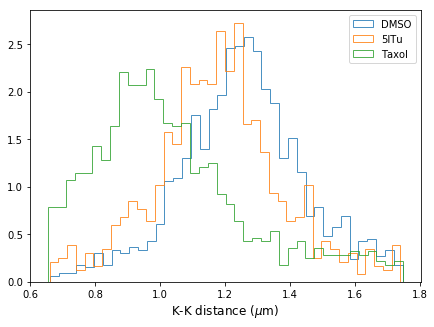

In [7]:
#Get histogram of K-K distance in each group
fs = 12
grped_df = df_prof_all.groupby('Group')
fig,ax = plt.subplots(figsize=(7,5))

#grp_to_plot = ['None','DMSO','5ITu','Taxol','DMSO_cont']
grp_to_plot = ['DMSO','5ITu','Taxol']
#grp_to_plot = ['DMSO','None']
for grp in grp_to_plot:
    plt.hist(grped_df.get_group(grp)['kkdist']*pixsize,bins=40,alpha=0.8,normed=True,histtype='step');
    
plt.legend(grp_to_plot)
plt.xlabel('K-K distance ($\mu$m)',fontsize=fs)
#fig.savefig('KKdistance_Histogram.pdf',facecolor=None,edgecolor=None)

In [8]:
grped_df.size()

Group
5ITu           869
DMSO          1214
DMSO_cont     1233
None          3074
Taxol         1026
Taxol+5ITu     207
dtype: int64

In [9]:
def findFWHM(prof,dx=0.1):
    x = np.arange(len(prof))
    f = sp.interpolate.interp1d(x,prof,kind='cubic')
    xnew,dx = np.linspace(0,np.max(x),np.int(np.max(x)/dx)+1,retstep=True)
    intp_prof = f(xnew)
    m = np.max(intp_prof)
    zero_crossings = np.where(np.diff(np.sign(intp_prof-m/2)))[0]
    return (zero_crossings[1]-zero_crossings[0])*dx

In [10]:
def int_at_kin(prof,kkdist):
    lenprof = len(prof)
    cen = (lenprof-1)/2.0
    return sp.interp([cen-kkdist/2.0,cen+kkdist/2.0],np.arange(lenprof),prof)

In [11]:
def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the SNR"
    D = len(signal) - len(kernel)
    kernel = np.hstack((kernel,np.zeros(D))) # zero pad the kernel to same length
    kernel = np.roll(kernel,-int(D/2.0)+2)
    H = fft(kernel)
    
    denom = H*np.conj(H) + lambd**2
    denom[denom<np.spacing(1)] = np.spacing(1)
    
    G = np.conj(H)/denom
    deconvolved = np.real(ifft(G*fft(signal)))
    
    return deconvolved

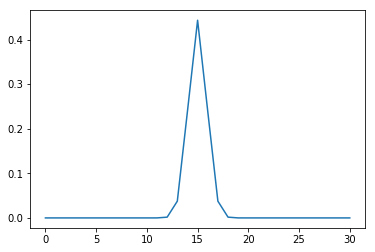

In [12]:
#1D PSF
x = np.arange(31)-15
sig = 0.9
psf = np.exp(-x**2/(2*sig**2))
psf = psf/np.sum(psf)
plt.plot(psf)

In [13]:
def getBinAvgProf(df_prof,nbins):
    # Average, sem of profiles within groups of pairs with similar K-K dists.
    labels,retbins = pd.qcut(df_prof['kkdist'],np.linspace(0,1,num=nbins+1),labels=np.arange(nbins),retbins=True)
    
    res_dicts = []
    for i in np.arange(nbins):
        df = df_prof.loc[labels==i]
        
        avgprof488 = df['prof488_norm'].mean()
        semprof488 = np.std(df['prof488_norm'].values,axis=0)/np.sqrt(df.shape[0])
        avgprof560 = df['prof560_norm'].mean()
        semprof560 = np.std(df['prof560_norm'].values,axis=0)/np.sqrt(df.shape[0])
        
        avgkkdist = df['kkdist'].mean()
        sdkkdist = df['kkdist'].std()
        
        avgintatkin = df.apply(lambda row:np.mean(int_at_kin(row.prof560_norm,row.kkdist)),axis=1).mean()
        semintatkin = np.std(df.apply(lambda row:np.mean(int_at_kin(row.prof488_norm,row.kkdist)),axis=1).values,axis=0)/np.sqrt(df.shape[0])
        
        res_dicts.append({'kkdist_range':(retbins[i],retbins[i+1]),'avgprof488':avgprof488,'avgprof560':avgprof560,
                          'semprof488':semprof488,'semprof560':semprof560,'avgintatkin':avgintatkin,'semintatkin':semintatkin,
                         'avgkkdist':avgkkdist,'sdkkdist':sdkkdist})
        
    return pd.DataFrame(res_dicts)

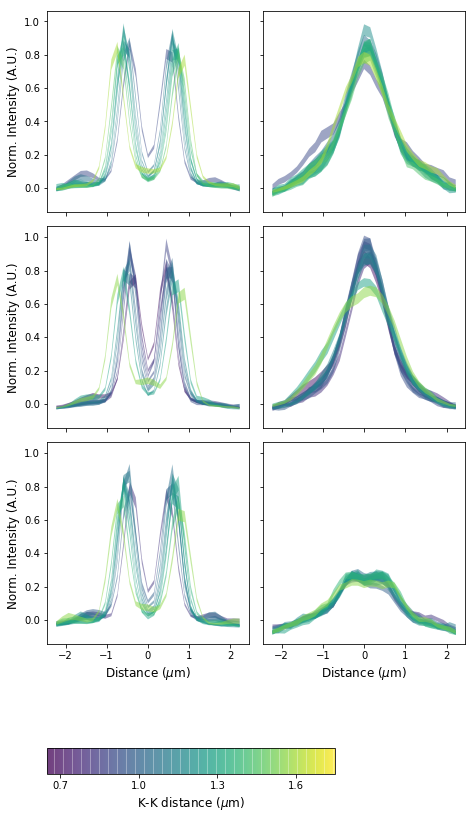

In [23]:
fs = 12
alph = 0.5

nbins = 10
df_res_list = [getBinAvgProf(df_prof_all[(df_prof_all['Group']=='DMSO')],nbins),
               getBinAvgProf(df_prof_all[(df_prof_all['Group']=='Taxol')],nbins),
               getBinAvgProf(df_prof_all[(df_prof_all['Group']=='5ITu')],nbins)]
# df_res_list = [getBinAvgProf(df_prof_all[(df_prof_all['Group']=='DMSO')],nbins),
#                 getBinAvgProf(df_prof_all[(df_prof_all['Group']=='5ITu')],nbins)]


norm = mpl.colors.Normalize(vmin=kkdistrange[0],vmax=kkdistrange[1])
# choose a colormap
c_m = cm.viridis
# create a ScalarMappable and initialize a data structure
s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


proflen = len(df_res_list[0].iloc[0]['avgprof488'])
x = (np.arange(proflen)-(proflen-1)/2.0)*pixsize

fig,ax = plt.subplots(nrows=len(df_res_list),ncols=2,figsize=(8,4*len(df_res_list)),sharex=True,sharey=True)
for j,df_res in enumerate(df_res_list):
    for i in range(nbins):
        ax[j][0].fill_between(x,df_res.iloc[i]['avgprof488']+df_res.iloc[i]['semprof488'],
                        df_res.iloc[i]['avgprof488']-df_res.iloc[i]['semprof488'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
        ax[j][1].fill_between(x,df_res.iloc[i]['avgprof560']+df_res.iloc[i]['semprof560'],
                        df_res.iloc[i]['avgprof560']-df_res.iloc[i]['semprof560'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
        
        ax[j][0].set_ylabel('Norm. Intensity (A.U.)',fontsize=fs)

ax[len(df_res_list)-1][0].set_xlabel('Distance ($\mu$m)',fontsize=fs)
ax[len(df_res_list)-1][1].set_xlabel('Distance ($\mu$m)',fontsize=fs)

plt.tight_layout()
fig.subplots_adjust(bottom=0.25,left=0.25)

cax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cb = fig.colorbar(s_m,orientation='horizontal',cax=cax,ticks=[0.7,1.0,1.3,1.6],alpha=alph)
cb.set_label('K-K distance ($\mu$m)',fontsize=fs)

fig.savefig('NormProfiles.pdf',facecolor=None,edgecolor=None)

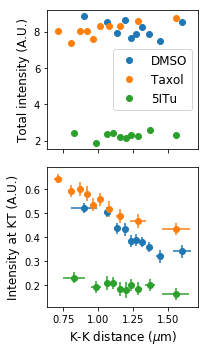

In [25]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(3,5),sharex=True)
for j,df_res in enumerate(df_res_list):
    ax[0].plot(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.sum),'o')
    ax[1].errorbar(df_res['avgkkdist']*pixsize,df_res['avgintatkin'],xerr=df_res['sdkkdist']*pixsize,yerr=df_res['semintatkin'],fmt='o')
    
ax[0].set_ylabel('Total intensity (A.U.)',fontsize=fs)
#ax[0].set_ylabel('Peak Intensity (A.U.)',fontsize=fs)
ax[0].legend(['DMSO','Taxol','5ITu'],fontsize=fs)
#ax[0].legend(['DMSO','5ITu'],fontsize=fs)
ax[1].set_ylabel('Intensity at KT (A.U.)',fontsize=fs)
ax[1].set_xlabel('K-K distance ($\mu$m)',fontsize=fs)

plt.tight_layout()

fig.savefig('AnalysisSummary.pdf',facecolor=None,edgecolor=None)

In [ ]:
# Plot profiles for each cell
grps_to_plot = ['None','DMSO']
nbins = 5

df_select = df_prof_all.loc[[grp in grps_to_plot for grp in df_prof_all['Group']]]
df_grped = df_select.groupby('Data Name')

norm = mpl.colors.Normalize(vmin=kkdistrange[0],vmax=kkdistrange[1])
# choose a colormap
c_m = cm.viridis
# create a ScalarMappable and initialize a data structure
s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

proflen = len(df_select.iloc[0]['prof560_norm'])
x = (np.arange(proflen)-(proflen-1)/2.0)*pixsize

# savedir = 'ProfilesForEachCells/'
for name, df in df_grped:
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,5))

    df_res = getBinAvgProf(df,nbins)
    for i in range(nbins):
        ax[0].fill_between(x,df_res.iloc[i]['avgprof488']+df_res.iloc[i]['semprof488'],
                        df_res.iloc[i]['avgprof488']-df_res.iloc[i]['semprof488'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
        ax[1].fill_between(x,df_res.iloc[i]['avgprof560']+df_res.iloc[i]['semprof560'],
                        df_res.iloc[i]['avgprof560']-df_res.iloc[i]['semprof560'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
    
    ax[2].plot(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.max),'o')

    ax[0].set_ylabel('Norm. Intensity (A.U.)',fontsize=fs)
    ax[0].set_xlabel('Distance ($\mu$m)',fontsize=fs)
    ax[1].set_xlabel('Distance ($\mu$m)',fontsize=fs)
    ax[2].set_xlabel('Distance ($\mu$m)',fontsize=fs)
    ax[2].set_ylabel('Peak intensity',fontsize=fs)

    cax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
    cb = fig.colorbar(s_m,orientation='horizontal',cax=cax,ticks=[0.7,1.0,1.3,1.6],alpha=alph)
    cb.set_label('K-K distance ($\mu$m)',fontsize=fs)
    
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25,left=0.25)
    
#    fig.savefig(savedir+name+'_None&DMSO.pdf')
